In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/SchwiftyNotebook_matrix_multiplication")' SchwiftyNotebook_matrix_multiplication

Installing packages:
	.package(path: "/home/ubuntu/workspace/fast-ai-swift/SchwiftyNotebook_matrix_multiplication")
		SchwiftyNotebook_matrix_multiplication
With SwiftPM flags: []
Working in: /tmp/tmp1zpv_c49/swift-install
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no vers

In [2]:
//export
import Path
import TensorFlow
import SchwiftyNotebook_matrix_multiplication

In [3]:
//export
public func reLU<T>(tensor: Tensor<T>) -> Tensor<T> where T : FloatingPoint, T: TensorFlowScalar {
    return max(tensor, 0)
}

In [4]:
//export
public func linearCombination<T>(inputs: Tensor<T>, weights: Tensor<T>, bias: Tensor<T>) -> Tensor<T> where T: FloatingPoint, T: TensorFlowScalar {
    return matmul(inputs, weights) + bias
}

In [5]:
// export
public typealias TensorFloat=Tensor<Float>
public func assertNearZero(_ tensor: TensorFloat, _ threshold: Float = 1e-3){
    assert(tensor < threshold, "Expected \(tensor) to be less than \(threshold)")
}

In [9]:
//export
import Dispatch

func getTimeUnit(_ nanoSeconds: Double) -> String {
    let powerOfTen = floor(log10(nanoSeconds))
    switch powerOfTen {
        case 1..<3:
            return "\(nanoSeconds) ns"
        case 3..<6:
            return "\(nanoSeconds/1e3) µs"
        case 6..<9: 
            return "\(nanoSeconds/1e6) ms"
        default: 
            return "\(nanoSeconds/1e9) s"
    }
}

// ⏰Time how long it takes to run the specified function, optionally taking
// the average across a number of repetitions.
public func withTime<T>(_ f: () -> T) -> T {
    let start = DispatchTime.now()
    let value = f()
    let end = DispatchTime.now()
    let nanoSeconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
    print("elapsed time: \(getTimeUnit(nanoSeconds))")
    return value
}

public func timeTrials(trials: Int = 1, _ f: () -> ()) {
    guard trials > 0 else { return }
    
    // Warmup
    if trials > 1 { f() }
    
    var times = [Double]()
    for _ in 1...trials {
        let start = DispatchTime.now()
        f()
        let end = DispatchTime.now()
        let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
        times.append(nanoseconds)
    }
    print("average: \(getTimeUnit(times.reduce(0.0, +)/Double(times.count))),   " +
          "min: \(getTimeUnit(times.reduce(times[0], min))),   " +
          "max: \(getTimeUnit(times.reduce(times[0], max)))")
}

In [10]:
//export
public func assertEquals(_ a: TensorFloat, _ b: TensorFloat, _ message: String) {
    // Check shapes match so broadcasting doesn't hide shape errors.
    assert(a.shape == b.shape)
    assertNearZero(a-b)
}

In [11]:
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [12]:
public let plotter = Python.import("matplotlib.pyplot")

# Data Setup

In [13]:
let n = 100
let inputPoints = TensorFloat(randomNormal: [100, 1])
let A = inputPoints.concatenated(with: TensorFloat(ones: inputPoints.shape), alongAxis: 1)
A.shape

▿ [100, 2]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 2


In [14]:
let yValidationPoints = matmul(A, TensorFloat([-2, 7]).expandingShape(at: 1)) + 
                (TensorFloat(randomNormal: inputPoints.shape, seed: (69, 420)) * 2.5)
yValidationPoints.shape

▿ [100, 1]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 1


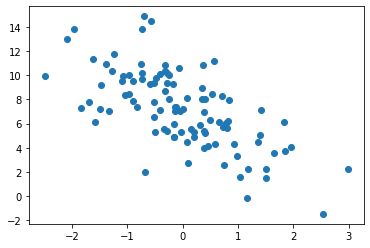

None


In [15]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
plotter.show()

# Model Creation

In [16]:
func squaredWithGradient(inputTensor: TensorFloat) -> (value: TensorFloat, 
                                                       gradientChain: (TensorFloat) -> TensorFloat) {
    return (value: inputTensor * inputTensor, 
            gradientChain: {ddx in 2 * inputTensor * ddx})
}

In [17]:
let testo = TensorFloat([[1,2,3,4,5],[1,2,3,4,5]])

In [19]:
let (squaredTensor, gradientChain) = squaredWithGradient(inputTensor: testo)

let myGradient = gradientChain(TensorFloat([1]))

assertEquals(squaredTensor, testo.squared(), "My square gradient should be equal")

In [20]:
func meanWithGradient(inputTensor: TensorFloat) -> (value: TensorFloat, 
                                                       gradientChain: (TensorFloat) -> TensorFloat) {
 let totalElements = Float(inputTensor.shape.dimensions.reduce(1) { accum, thing in accum * thing })
 return (value: inputTensor.sum(squeezingAxes: Array(inputTensor.shape.indices)) / totalElements,
         gradientChain: {ddx in TensorFloat([1]) / totalElements * ddx})   
}

In [21]:
let (mean, gradientChain) = meanWithGradient(inputTensor: testo)

let myGradient = gradientChain(TensorFloat([1]))
let theirGradient = gradient { x in x.mean()} (testo)

assert(mean == testo.mean(), "Mean not the same")
assert(myGradient == theirGradient, "Gradient not the same")

In [22]:
let (squaredTensor, squaredGradientChain) = squaredWithGradient(inputTensor: testo)
let (mean, meanChain) = meanWithGradient(inputTensor: squaredTensor)

let myGradient = squaredGradientChain(meanChain(TensorFloat([1])))
let theirGradient = gradient { x in x.squared().mean()}(testo)

assert(mean == testo.squared().mean(), "Squared Mean not same")
assert(myGradient == theirGradient, "Squared Mean Gradients not the same")

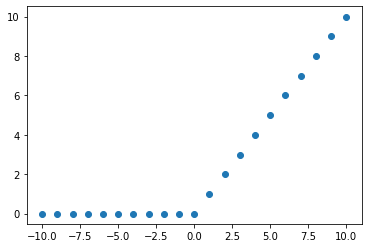

None


In [23]:
// The deriviative of reLU is 1 where ever the unit is active (eg greater than zero)
// and 0 wherever the unit is not active. 

//  That's because the slope of the derivative is 1 where x is > 0. When x = 0 y = 0, when x = 1 y = 1, 
// when x = 2 y = 2, when x = 3 y = 3. so on, (it's a line with a slope of one)

// So maybe just take the gradients that correspond to a component in the input that is 
// greater than zero?
let testArray = TensorFloat(Array(-10...10).map{Float($0)})
plotter.scatter(x: testArray.makeNumpyArray(), 
                y: reLU(tensor: testArray).makeNumpyArray())
plotter.show()

Dat Slope is one boi! 

In [24]:
func reLUAndGradient(inputTensor: TensorFloat) -> (value: TensorFloat, 
                                                   gradientChain: (TensorFloat) -> TensorFloat){
    return (value: max(0.0, inputTensor), 
            gradientChain: {ddx in ddx.replacing(with: TensorFloat(zeros: ddx.shape), where: inputTensor .< 0.0 )})
}

In [26]:
let (reluValue, reluGradientChain) = reLUAndGradient(inputTensor: testArray)
let libraryReluValue = relu(testArray)

assertEquals(reluValue, libraryReluValue, "Relu gradient should be equal")

**Linear combination**
---

`womboCombo = input * weightParameter + biasParameter`

Partial Derivative with respects to input = `weightParameter`

Partial Derivative with respects to weightParameter = `input`

Partial Derivative with respects to bias = `1`

In [27]:
// Matrix Shapez
// M x N * N x O = M x O

// ddx shape = M x O

func linearCombinationAndGradient(inputTensor: TensorFloat, 
                                  weightParameter: TensorFloat,
                                  biasParameter: TensorFloat) -> (value: TensorFloat, 
                                                                  gradientChain: (TensorFloat) -> (TensorFloat, TensorFloat, TensorFloat)) {
    return (value: matmul(inputTensor, weightParameter) + biasParameter, 
            gradientChain: { ddx in 
                           ( matmul(ddx, weightParameter.transposed()),
                             matmul(inputTensor.transposed(),  ddx),
                             ddx.unbroadcasted(to: biasParameter.shape)
                           )
                           })
}

In [28]:
var weightParameter = TensorFloat([5, 3]).expandingShape(at: 1)
let learningRate: Float = 5e-2
var biasParameter = TensorFloat(zeros: [1])

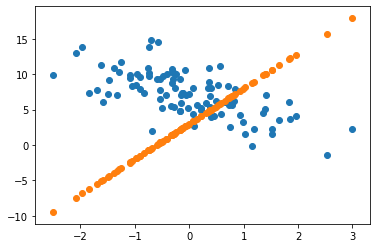

None


In [29]:
//first guess
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: matmul(A, weightParameter).makeNumpyArray())
plotter.show()

In [30]:
timeTrials(trials: 100) {
    let (activations, activationChain) = linearCombinationAndGradient(inputTensor: A, 
                                                                      weightParameter: weightParameter, 
                                                                      biasParameter: biasParameter)
    let error = activations - yValidationPoints
    let (squareValue, squareGradient) = squaredWithGradient(inputTensor: error)
    let (meanValue, meanGradient) = meanWithGradient(inputTensor: squareValue)
    
    // Time to go backward bois!
    let ddxMean = meanGradient(TensorFloat([1]))
    let ddxSquare = squareGradient(ddxMean)
    let (ddxInput, ddxWeightParam, ddxBias) = activationChain(ddxSquare)
    
    weightParameter -= learningRate * ddxWeightParam
    
}

average: 1.46650102 ms,   min: 1.255688 ms,   max: 1.53111 ms


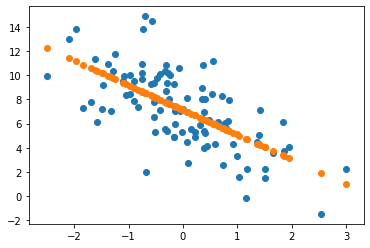

None


In [31]:
//learned guess
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: matmul(A, weightParameter).makeNumpyArray())
plotter.show()

In [32]:
print(weightParameter)

[[-2.0426924],
 [ 7.1173325]]


Very nice!!!!

**Time to make it purdy**

In [85]:
// loss function
func meanSquaredErrorAndGradient(yHat: TensorFloat, y: TensorFloat) -> (value: TensorFloat,
                                                                        gradient: () -> TensorFloat) {
    assert(yHat.shape == y.shape, "Expected inputs to be the same size")
    let error = yHat - y
    let (squareValue, squareGradient) = squaredWithGradient(inputTensor: error)
    let (meanValue, meanGradient) = meanWithGradient(inputTensor: squareValue)
    
    return (value: meanValue, gradient: { squareGradient(meanGradient(TensorFloat([1]))) })
}

In [86]:
struct AlexLayer {
    let activationFunction: (TensorFloat) -> (value: TensorFloat, gradientChain: (TensorFloat) -> TensorFloat)
 
}

(Function)
